# MIDS W207 Fall 2017 Final Project:  San Francisco Crime Classification
## EDA, Data Cleaning and Feature Engineering
Laura Williams, Kim Vignola, Cyprian Gascoigne  
SF Crime Classification

## Objectives & Sources

Kaggle has a competition for classifying crime in San Francisco County based on nearly 15 years of historical data. The goal of this project is get the lowest Log-Loss possible through feature engineering, appropriate model selection and including external data sources where relevant.  External Sources include weather data from San Francisco County and locations of police departments which is being used to calcuate distance of crimes from police stations. Weather data sources

Weather data Reference:
Source: https://www.ncdc.noaa.gov/cdo-web/search
Report: Daily Summaries, Date Range: 1/1/2003 - 12/31/2015, Search for: Counties/San Francisco, Station: SAN FRANCISCO DOWNTOWN, CA US, Metrics: Precipitation, Maximum Temperature, Minimum Temperature.

Police Department Location Reference:
http://sanfranciscopolice.org/police-district-maps
Addresses were used to find latitude and longitude for each station.

## Features added
Buckets for month, year, dayparts, holidays, seasons and first day of the month.
Max Temperature, Min Temperature and Precipitation and Distance from Police Station  (as described above)
Rotational Data was included to tie together latitude and longitude.



## Notebook Setup Details

This notebook reads raw data (saved in a zip file) from Kaggle, processes and organizes the data for training a variety of machine learning models, and outputs the data as zipped csv files that other notebooks can unzip and use to train different models. Resulting zipped files will include: 

1) train_data.csv and train_labels.csv - includes 80% of the total training data, for training models that are not yet going to be submitted to Kaggle

2) dev_data.csv and dev_labels.csv - includes 20% of the total training data, for testing models before they are submitted to Kaggle

3) train_data_all.csv and train_labels_all.csv - includes all the training data. After testing models with the train and dev data split above, train the model from this full set of data for submission to Kaggle.

4) test_data_all.csv - create predictions on this data for submission to Kaggle.

#### NOTE: holidays package is not native with anaconda and may need to be installed

In [31]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import zipfile
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import holidays
from math import sqrt
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

In [2]:
# Unzip raw data into a subdirectory 
unzip_files = zipfile.ZipFile("raw_data.zip", "r")
unzip_files.extractall("raw_data")
unzip_files.close()

In [3]:
# Read CSV files into pandas dataframes
train = pd.read_csv("raw_data/train.csv")
test = pd.read_csv("raw_data/test.csv")
weather = pd.read_csv("raw_data/SF_county.csv")

In [4]:
# The EDA indicates there are erroneous latitude values (90 degrees)
# The majority of records do not contain a resolution 
# (though this field will be removed as it is not present in test data)
train.describe(include='all')

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
count,878049,878049,878049,878049,878049,878049,878049,878049.000000,878049.000000
unique,389257,39,879,7,10,17,23228,NaN,NaN
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,NaN,NaN
freq,185,174900,60022,133734,157182,526790,26533,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.422616,37.771020
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030354,0.456893
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.432952,37.752427
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.416420,37.775421
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.406959,37.784369


In [5]:
test.describe(include='all')

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
count,884262.000000,884262,884262,884262,884262,884262.000000,884262.000000
unique,NaN,392173,7,10,23184,NaN,NaN
top,NaN,2010-01-01 00:01:00,Friday,SOUTHERN,800 Block of BRYANT ST,NaN,NaN
freq,NaN,150,134703,157456,26984,NaN,NaN
mean,442130.500000,NaN,NaN,NaN,NaN,-122.422693,37.771476
std,255264.596206,NaN,NaN,NaN,NaN,0.030985,0.484824
min,0.000000,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,221065.250000,NaN,NaN,NaN,NaN,-122.433069,37.752374
50%,442130.500000,NaN,NaN,NaN,NaN,-122.416517,37.775421
75%,663195.750000,NaN,NaN,NaN,NaN,-122.406959,37.784353


In [6]:
# Support that the majority of records do not contain a resolution.
print(len(train.loc[train['Resolution'] == "NONE"]))

526790


In [8]:
# Other than Resolution, there are no missing values in the dataset.
null_values = pd.isnull(train)
print(null_values.sum(axis=0))

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64


In [9]:
# While the number of erroneous Y values is small, they need to be addressed for data visualization and reduced noise.
print(len(train.loc[train['Y'] > 40]))

67


In [10]:
# The corresponding longitude values for these same records also need to be addressed.
print(len(train.loc[train['X'] > -122]))

67


In [11]:
# Set cases with 90 degree latitude to the median of the district where the crime occured.
districts = set(train["PdDistrict"])
mediansY = {el:0 for el in districts}
for district in districts:
    mediansY[district] = train["Y"][train["PdDistrict"] == district].median()
mediansX = {el:0 for el in districts}
for district in districts:
    mediansX[district] = train["X"][train["PdDistrict"] == district].median()
    
train.loc[train.Y > 38, "Y"] = train[train.Y > 38]["PdDistrict"].map(lambda x: mediansY[x])
test.loc[test.Y > 38, "Y"] = test[test.Y > 38]["PdDistrict"].map(lambda x: mediansY[x])


train.loc[train.X > -122, "X"] = train[train.X > -122]["PdDistrict"].map(lambda x: mediansX[x])
test.loc[test.X > -122, "X"] = test[test.X > -122]["PdDistrict"].map(lambda x: mediansX[x])

In [12]:
# Review the top crime categories to identify those to include in visualizations
train["Category"].value_counts().head(10)

LARCENY/THEFT     174900
OTHER OFFENSES    126182
NON-CRIMINAL       92304
ASSAULT            76876
DRUG/NARCOTIC      53971
VEHICLE THEFT      53781
VANDALISM          44725
WARRANTS           42214
BURGLARY           36755
SUSPICIOUS OCC     31414
Name: Category, dtype: int64

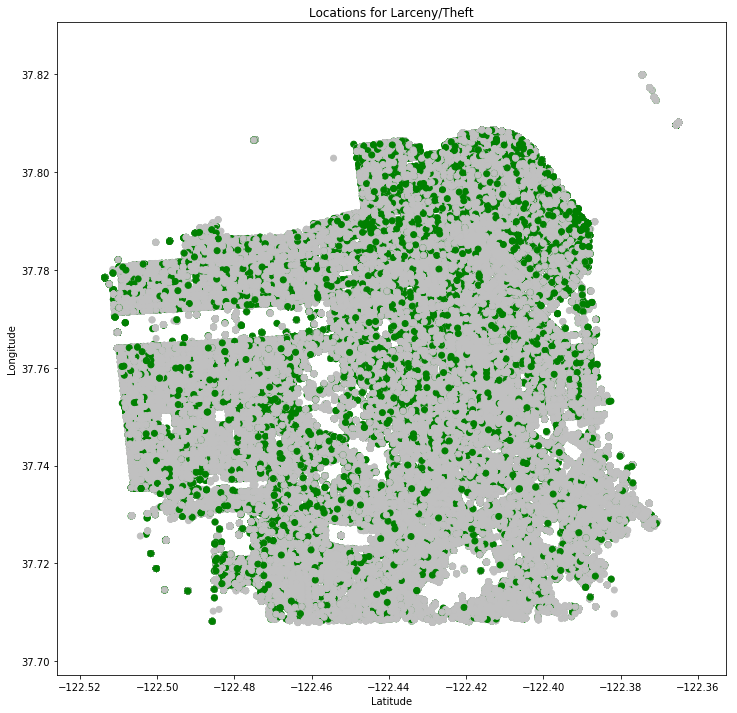

In [13]:
# The top crime category is dispersed throughout the region but does skew to the northeast of the city.
fig = plt.figure(figsize=(12,12))
plt.scatter(train["X"], train["Y"], c=['green' if x=="LARCENY/THEFT" else 'silver' for x in train["Category"]])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Locations for Larceny/Theft')
plt.show()

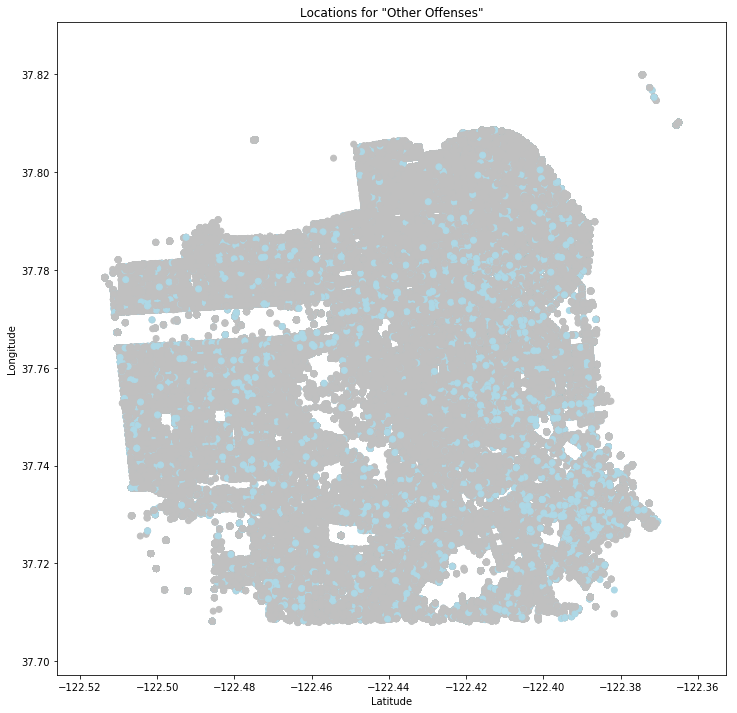

In [14]:
# The #2 Category "Other Offenses" leans toward the southeast of the city
fig = plt.figure(figsize=(12,12))
plt.scatter(train["X"], train["Y"], c=['lightblue' if x=="OTHER OFFENSES" else 'silver' for x in train["Category"]])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Locations for "Other Offenses"')
plt.show()

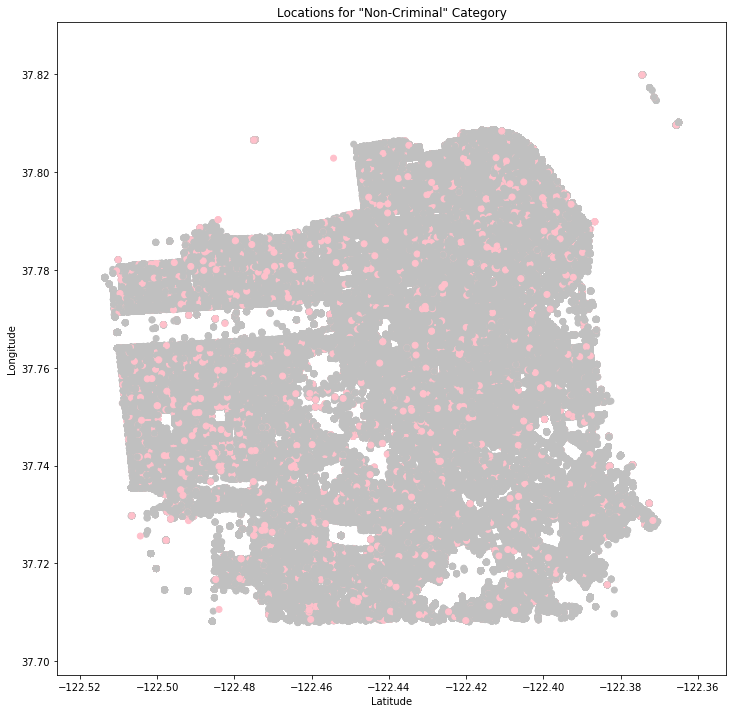

In [15]:
# The Non-Criminal Category points has relatively more activity in the west
fig = plt.figure(figsize=(12,12))
plt.scatter(train["X"], train["Y"], c=['pink' if x=="NON-CRIMINAL" else 'silver' for x in train["Category"]])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Locations for "Non-Criminal" Category')
plt.show()

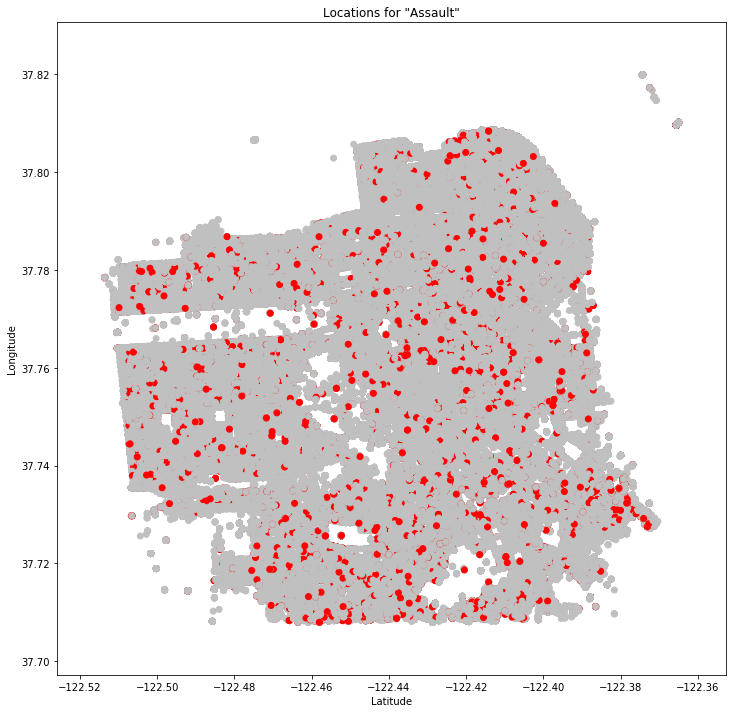

In [16]:
#  Assaults are spread fairly evenly throughout the county
fig = plt.figure(figsize=(12,12))
plt.scatter(train["X"], train["Y"], c=['red' if x=="ASSAULT" else 'silver' for x in train["Category"]])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Locations for "Assault"')
plt.show()

In [13]:
# Top crimes are likely to occur on New Year's Day; holidays will be included as a feature.
train["Dates"].value_counts().head(20)

2011-01-01 00:01:00    185
2006-01-01 00:01:00    136
2012-01-01 00:01:00     94
2006-01-01 12:00:00     63
2007-06-01 00:01:00     61
2006-06-01 00:01:00     58
2010-06-01 00:01:00     56
2010-08-01 00:01:00     55
2008-04-01 00:01:00     53
2013-11-01 00:01:00     52
2008-11-01 00:01:00     51
2006-07-01 00:01:00     51
2013-05-01 00:01:00     51
2010-11-01 00:01:00     51
2005-06-01 00:01:00     50
2011-06-01 00:01:00     50
2005-07-01 00:01:00     49
2008-06-01 00:01:00     48
2009-09-01 00:01:00     46
2006-11-01 00:01:00     46
Name: Dates, dtype: int64

In [14]:
# Create new buckets for month, day, year, hour and sesaons to provide additional feature dimensions.

train["month"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").month)
train["year"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").year)
train["hour"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").hour)
train["day"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").day)

test["month"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").month)
test["year"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").year)
test["hour"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").hour)
test["day"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").day)

# map holidays
US_Holidays = holidays.UnitedStates()
train["holidays"] = train["Dates"].map(lambda x: x in US_Holidays)
test["holidays"] = test["Dates"].map(lambda x: x in US_Holidays)


In [14]:
# Crimes are most likely to occur on the first day of the month.
train["day"].value_counts().head(10)

1     32167
22    30589
8     30339
21    30038
19    30012
20    29963
4     29905
18    29793
7     29685
5     29557
Name: day, dtype: int64

In [17]:
# Pull out first day of the month as it ranks first for crime volume and specific crimes may be associated with the day
train["first_day"] = [1 if x==1 else 0 for x in train["day"]]
test["first_day"] = [1 if x==1 else 0 for x in test["day"]]

In [18]:
# Year 2015 only includes data from January through May. We will bucket month_year to tied months together with years.
print((train['month'].loc[train['year'] == 2015]).value_counts())

3    6851
4    6609
2    6008
1    5866
5    2250
Name: month, dtype: int64


In [19]:
# create a bucket variable for month_year

train["month_year"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
train["month_year"] = train["month_year"].map(lambda x: datetime.strftime(x,"%Y-%m"))

test["month_year"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
test["month_year"] = test["month_year"].map(lambda x: datetime.strftime(x,"%Y-%m"))

In [20]:
# parse out day of year for bucketing seasons

train["doy"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").timetuple().tm_yday)
test["doy"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").timetuple().tm_yday)

train["spring"] = [1 if x in range(81,173) else 0 for x in train["doy"]]
train["summer"] = [1 if x in range(173,265) else 0 for x in train["doy"]]
train["fall"] = [1 if x in range(265,356) else 0 for x in train["doy"]]
train["winter"] = [1 if x in range(1,81) or x in range(356,366) else 0 for x in train["doy"]]

test["spring"] = [1 if x in range(81,173) else 0 for x in test["doy"]]
test["summer"] = [1 if x in range(173,265) else 0 for x in test["doy"]]
test["fall"] = [1 if x in range(265,356) else 0 for x in test["doy"]]
test["winter"] = [1 if x in range(1,81) or x in range(356,366) else 0 for x in test["doy"]]

In [21]:
# create a dictionary for bucketing hours
time_periods = {6:"early_morning", 7:"early_morning", 8:"early_morning", 
               9:"late_morning", 10:"late_morning", 11:"late_morning",
              12:"early_afternoon", 13:"early_afternoon", 14:"early_afternoon",
              15:"late_afternoon", 16:"late_afternoon", 17:"late_afternoon",
              18:"early_evening",  19:"early_evening",  20:"early_evening",
              21:"late_evening", 22:"late_evening", 23:"late_evening",
              0:"late_night", 1:"late_night", 2:"late_night",
              3:"late_night", 4:"late_night", 5:"late_night"}

# map time periods to dayparts
train["dayparts"] = train["hour"].map(time_periods)
test["dayparts"] = test["hour"].map(time_periods)

In [15]:
# clean up weather data
del weather['NAME']
del weather['SNOW']

In [16]:
# drop time from train and test date fields to be able to map Dates against weather data; remove hyphens too.
train["Dates"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
train["Dates"] = train["Dates"].map(lambda x: datetime.strftime(x,"%Y%m%d"))
test["Dates"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
test["Dates"] = test["Dates"].map(lambda x: datetime.strftime(x,"%Y%m%d"))

# Convert Weather DATE to same format as train and test data
weather["DATE"] = weather["DATE"].map(lambda x: datetime.strptime(x,"%m/%d/%y"))
weather["DATE"] = weather["DATE"].map(lambda x: datetime.strftime(x,"%Y%m%d"))

In [17]:
# convert date objects to numeric
train["Dates"] = pd.to_numeric(train["Dates"])
test["Dates"] = pd.to_numeric(test["Dates"])
weather["DATE"] = pd.to_numeric(weather["DATE"])
print(type(train["Dates"][0]))

<class 'numpy.int64'>


In [18]:
# left merge weather data based on dates
weather_train = pd.merge(train, weather, how='left', left_on="Dates", right_on = "DATE")
del weather_train['DATE']
weather_test = pd.merge(test, weather, how='left', left_on="Dates", right_on = "DATE")
del weather_test['DATE']

In [19]:
#print new shape
print(weather_train.shape)
print(weather_test.shape)

print("Cases fixed in the train data =", len(train[train.Y>38]))
print("Cases fixed in the test data =", len(test[test.Y > 38]))

(878049, 17)
(884262, 15)
Cases fixed in the train data = 0
Cases fixed in the test data = 0


In [20]:
#Add additional positional arguments. First one is distance to nearest police station. 
# We use Euclidean distance since curvature of the earth doesn't matter for small distances.

def dist(p1, p2):
    return sqrt((p2[1]-p1[0])**2 + (p2[0]-p1[1])**2)

PStations = {'Central Station':  (37.798732, -122.409919), 'Southern Station': (37.772380,-122.389412), 
             'Bayview':  (37.729732, -122.397981), 'Mission': (37.762849, -122.422005), 'Northern': (37.780190, -122.432445), 
             'Park': (37.767797, -122.455287), 'Richmond': (37.779928, -122.464467), 'Ingleside': (37.724676, -122.446215), 
             'Taraval': (37.782988, -122.483874), 'Tenderloin': (37.783669, -122.412896)}

def mindist(p1, l):
    return min([dist(p1,x) for x in l])

weather_train['d_police'] = weather_train.apply(lambda x : mindist((x.X, x.Y), PStations.values()), axis = 1)
weather_test['d_police'] = weather_test.apply(lambda x : mindist((x.X, x.Y), PStations.values()), axis = 1)

In [29]:
# Second, incorporate rotational data for better spatial understanding.
weather_train["rot_45_X"] = .707*weather_train["Y"] + .707*weather_train["X"]
weather_train["rot_45_Y"] = .707* weather_train["Y"] - .707* weather_train["X"]

weather_train["rot_30_X"] = (1.732/2)*weather_train["X"] + (1./2)*weather_train["Y"]
weather_train["rot_30_Y"] = (1.732/2)*weather_train["Y"] - (1./2)*weather_train["X"]

weather_train["rot_60_X"] = (1./2)*weather_train["X"] + (1.732/2)*weather_train["Y"]
weather_train["rot_60_Y"] = (1./2)*weather_train["Y"] - (1.732/2)*weather_train["X"]

weather_train["radial_r"] = np.sqrt(np.power(weather_train["Y"],2) + np.power(weather_train["X"],2))

#Test data
weather_test["rot_45_X"] = .707*weather_test["Y"] + .707*weather_test["X"]
weather_test["rot_45_Y"] = .707* weather_test["Y"] - .707* weather_test["X"]

weather_test["rot_30_X"] = (1.732/2)*weather_test["X"] + (1./2)*weather_test["Y"]
weather_test["rot_30_Y"] = (1.732/2)*weather_test["Y"] - (1./2)*weather_test["X"]

weather_test["rot_60_X"] = (1./2)*weather_test["X"] + (1.732/2)*weather_test["Y"]
weather_test["rot_60_Y"] = (1./2)*weather_test["Y"] - (1.732/2)*weather_test["X"]

weather_test["radial_r"] = np.sqrt(np.power(weather_test["Y"],2) + np.power(weather_test["X"],2))

In [21]:
print(train.columns)
print(weather_train.columns)
print(test.columns)
print(weather_test.columns)

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'month', 'year', 'hour', 'day',
       'holidays'],
      dtype='object')
Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'month', 'year', 'hour', 'day',
       'holidays', 'PRCP', 'TMAX', 'TMIN', 'd_police'],
      dtype='object')
Index(['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'month',
       'year', 'hour', 'day', 'holidays'],
      dtype='object')
Index(['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'month',
       'year', 'hour', 'day', 'holidays', 'PRCP', 'TMAX', 'TMIN', 'd_police'],
      dtype='object')


In [22]:
weather_train["holidays"] = weather_train["holidays"].astype(int)
weather_test["holidays"] = weather_test["holidays"].astype(int)
print(type(weather_train["holidays"][0]))
print(type(weather_test["holidays"][0]))


<class 'numpy.int64'>
<class 'numpy.int64'>


In [23]:
weather_train.dtypes

Dates           int64
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
month           int64
year            int64
hour            int64
day             int64
holidays        int64
PRCP          float64
TMAX            int64
TMIN            int64
d_police      float64
dtype: object

In [24]:
weather_test.dtypes

Id              int64
Dates           int64
DayOfWeek      object
PdDistrict     object
Address        object
X             float64
Y             float64
month           int64
year            int64
hour            int64
day             int64
holidays        int64
PRCP          float64
TMAX            int64
TMIN            int64
d_police      float64
dtype: object

NOTE:  The first code chunk below is intended to be run to represent all features created and modified above. 

The second code chunk is intended to be run with a smaller feature subset without bucketing.

In [48]:
# Encode string features into numeric features
LE = preprocessing.LabelEncoder()

train_data_all = pd.get_dummies(weather_train, columns = ['DayOfWeek', 'PdDistrict',
       'month', 'year', 'dayparts'])
del train_data_all["Dates"]
del train_data_all["Descript"]
del train_data_all["Resolution"]
del train_data_all["day"]
del train_data_all["doy"]
del train_data_all["Address"]
train_labels_all = np.array(train_data_all['Category'])
del train_data_all["Category"]

train_data_all.reindex()

test_data_all = pd.get_dummies(weather_test, columns = ['DayOfWeek', 'PdDistrict',
       'month', 'year','dayparts'])

del test_data_all["Id"]
del test_data_all["day"]
del test_data_all["doy"]
del test_data_all["Dates"]
del test_data_all["Address"]
                                 
LE.fit(train_data_all['month_year'])
train_data_all['month_year'] = LE.transform(train_data_all['month_year'])
test_data_all['month_year'] = LE.transform(test_data_all['month_year'])    
    
print(test_data_all.columns == train_data_all.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


In [25]:
# For feature subset NOT the full feature set

# I could not figure out how to create a new variable that didn't
# push these changes back to weather_train. 
# This code would be better if a new variable were used here.

del weather_train["Dates"]
del weather_train["Descript"]
del weather_train["Resolution"]
del weather_train["Address"]
del weather_train["PdDistrict"]
del weather_train["DayOfWeek"]

# Create labels
train_labels_all = np.array(weather_train['Category'])
del weather_train["Category"]

weather_train.reindex()


del weather_test["Id"]
del weather_test["Dates"]
del weather_test["Address"]
del weather_test["PdDistrict"]
del weather_test["DayOfWeek"]

weather_test.reindex()

train_data_all = pd.DataFrame(weather_train)
test_data_all = pd.DataFrame(weather_test)

In [26]:
test_data_all.describe(include='all')

,X,Y,month,year,hour,day,holidays,PRCP,TMAX,TMIN,d_police
count,884262.000000,884262.000000,884262.000000,884262.000000,884262.000000,884262.000000,884262.000000,884262.000000,884262.000000,884262.00000,884262.000000
mean,-122.422858,37.766987,6.314065,2008.703743,13.396023,15.650294,0.024788,0.054380,64.058228,51.19240,0.011090
std,0.025345,0.024179,3.467064,3.637850,6.558899,8.874769,0.155478,0.199042,7.217374,4.36742,0.007902
min,-122.513642,37.707879,1.000000,2003.000000,0.000000,1.000000,0.000000,0.000000,44.000000,37.00000,0.000064
25%,-122.433069,37.752374,3.000000,2005.000000,9.000000,8.000000,0.000000,0.000000,59.000000,48.00000,0.005556
50%,-122.416517,37.775421,6.000000,2009.000000,14.000000,16.000000,0.000000,0.000000,63.000000,51.00000,0.009539
75%,-122.406959,37.784353,9.000000,2012.000000,19.000000,23.000000,0.000000,0.000000,67.000000,54.00000,0.014316
max,-122.364751,37.820621,12.000000,2015.000000,23.000000,31.000000,1.000000,2.610000,97.000000,67.00000,0.058175


In [27]:
train_data_all.describe(include='all')

,X,Y,month,year,hour,day,holidays,PRCP,TMAX,TMIN,d_police
count,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000
mean,-122.422763,37.767035,6.436509,2008.712046,13.412655,15.570623,0.031928,0.054124,64.225538,51.411590,0.011045
std,0.025284,0.024165,3.428972,3.631194,6.549573,8.783005,0.175807,0.208316,7.446151,4.474968,0.007888
min,-122.513642,37.707879,1.000000,2003.000000,0.000000,1.000000,0.000000,0.000000,45.000000,36.000000,0.000064
25%,-122.432952,37.752427,3.000000,2006.000000,9.000000,8.000000,0.000000,0.000000,59.000000,48.000000,0.005513
50%,-122.416420,37.775421,6.000000,2009.000000,14.000000,16.000000,0.000000,0.000000,64.000000,52.000000,0.009501
75%,-122.406959,37.784368,9.000000,2012.000000,19.000000,23.000000,0.000000,0.000000,68.000000,54.000000,0.014285
max,-122.364937,37.819975,12.000000,2015.000000,23.000000,31.000000,1.000000,3.400000,98.000000,68.000000,0.058175


In [45]:
# Normalization
#test_data_all = (test_data_all - train_data_all.mean())/(train_data_all.std())
#train_data_all = (train_data_all - train_data_all.mean())/(train_data_all.std())

In [28]:
# Normalization
test_data_all = (test_data_all - train_data_all.mean())/(train_data_all.max() - train_data_all.min())
train_data_all = (train_data_all - train_data_all.mean())/(train_data_all.max() - train_data_all.min())

In [29]:
print(test_data_all[0:5])

          X         Y     month      year      hour       day  holidays  \
0  0.155849 -0.285325 -0.130592  0.523996  0.416841 -0.185687 -0.031928   
1  0.210083 -0.308685 -0.130592  0.523996  0.416841 -0.185687 -0.031928   
2 -0.021780  0.224606 -0.130592  0.523996  0.416841 -0.185687 -0.031928   
3 -0.098388 -0.406996 -0.130592  0.523996  0.416841 -0.185687 -0.031928   
4 -0.098388 -0.406996 -0.130592  0.523996  0.416841 -0.185687 -0.031928   

       PRCP      TMAX      TMIN  d_police  
0 -0.015919 -0.136331 -0.075362 -0.094458  
1 -0.015919 -0.136331 -0.075362 -0.069616  
2 -0.015919 -0.136331 -0.075362  0.044651  
3 -0.015919 -0.136331 -0.075362 -0.028220  
4 -0.015919 -0.136331 -0.075362 -0.028220  


In [30]:
# Shuffle data and set aside 20% as development data
train_data_all = train_data_all.values
test_data_all = test_data_all.values
n = train_data_all.shape[0]

np.random.seed(0)

shuffle = np.random.permutation(np.arange(train_data_all.shape[0]))

train_data_all = train_data_all[shuffle]
train_labels_all = train_labels_all[shuffle]

n_train = int(0.8*n)

train_data = train_data_all[:n_train,:]
train_labels = train_labels_all[:n_train]
dev_data = train_data_all[n_train:,:]
dev_labels = train_labels_all[n_train:]

The Random Forest classifiers below are set up to run several different things:

The first model has basic sub-optimal parameters to quickly confirm that no errors are returned by running the data through the model.

The second model is set with optimal parameters to determine the best possible log loss score on the dev data.

The third model is trained on the full set of training data, predictions to submit to Kaggle.

In [32]:
# Basic model - to quickly check for errors

# Set up variables
n = 10
depth = 2
features = 'sqrt'
# Train the model and create predictions
RF = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=1)
RF.fit(train_data, train_labels)
pp = RF.predict_proba(dev_data)
logloss = metrics.log_loss(dev_labels, pp)
print(logloss)

2.62380720459


In [ ]:
# Optimal hyperparameters with random forest model
# Note that on a dataset with a large number of features this may take about 20-30 minutes

# Also the optimal hyperparameters might change with different types and number of features
# So if the feature set changes dramatically, it's worth taking some time to re-tune hyperparameters

# Set up variables
n = 150
depth = 16
features = 0.40

# Train the model and create predictions
RF = RandomForestClassifier(n_estimators=n, 
                            max_depth=depth, 
                            max_features=features, 
                            n_jobs=1, 
                            random_state=0)
RF.fit(train_data, train_labels)
pp = RF.predict_proba(dev_data)
logloss = metrics.log_loss(dev_labels, pp)
print(logloss)

In [ ]:
def TrainFinalRF(data, labels, test_data, n, depth, features):
    """Train on full dataset. Make predictions on test data.
    """
    RF = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=1)
    RF.fit(data, labels)
    pp = RF.predict_proba(test_data)
    return RF, pp

# Train model with optimal hyperparameters on the full set of training data
# Make predictions on the test data
n = 150
depth = 16
features = 0.40
RF, pp = TrainFinalRF(train_data_all, train_labels_all, test_data_all, n, depth, features)


The code below creates a zipped csv file of the predicted probabilities (created in the code chunk previous to this one) for submission to Kaggle.

In [ ]:
# Set up predictions for submission to Kaggle 


headers = ["ARSON","ASSAULT","BAD CHECKS","BRIBERY","BURGLARY","DISORDERLY CONDUCT","DRIVING UNDER THE INFLUENCE",
           "DRUG/NARCOTIC","DRUNKENNESS","EMBEZZLEMENT","EXTORTION","FAMILY OFFENSES","FORGERY/COUNTERFEITING",
           "FRAUD","GAMBLING","KIDNAPPING","LARCENY/THEFT","LIQUOR LAWS","LOITERING","MISSING PERSON","NON-CRIMINAL",
           "OTHER OFFENSES","PORNOGRAPHY/OBSCENE MAT","PROSTITUTION","RECOVERED VEHICLE","ROBBERY","RUNAWAY",
           "SECONDARY CODES","SEX OFFENSES FORCIBLE","SEX OFFENSES NON FORCIBLE","STOLEN PROPERTY","SUICIDE",
           "SUSPICIOUS OCC","TREA","TRESPASS","VANDALISM","VEHICLE THEFT","WARRANTS","WEAPON LAWS"]
data = pd.DataFrame(data=pp, 
                    index=[x for x in range(len(test_data_all))], 
                    columns=headers)
data.columns.name ="Id"

In [ ]:
data.to_csv('Williams_Gascoigne_Vignola_RandomForest_ADDNAME.csv', index_label = "Id")

In [ ]:
zip_probs = zipfile.ZipFile("Williams_Gascoigne_Vignola_RandomForest_ADDNAME.zip", "w")
zip_probs.write("Williams_Gascoigne_Vignola_RandomForest_ADDNAME.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_probs.close()

The code below will create zipped csv files of the current dataset in this notebook to be run through models in other notebooks.  

Provided this notebook and the notebook in which you want to use this dataset are in the same directory, all you have to do is run the code chunks below, and then run the code chunks at the beginning of any of the notebooks with models, and it will work seamlessly.

In [54]:
# print shapes and some data to compare before and after csv conversion
print("train_data shape is", train_data.shape)
print("train_labels shape is", train_labels.shape)
print("dev_data shape is", dev_data.shape)
print("dev_labels shape is", dev_labels.shape)
print("train_data_all shape is", train_data_all.shape)
print("train_labels_all shape is", train_labels_all.shape)
print("test_data_all shape is", test_data_all.shape)

train_data shape is (702439, 70)
train_labels shape is (702439,)
dev_data shape is (175610, 70)
dev_labels shape is (175610,)
train_data_all shape is (878049, 70)
train_labels_all shape is (878049,)
test_data_all shape is (884262, 70)


In [55]:
# Save data as CSV files in a subdirectory

# NOTE: mkdir will make a "csv" directory in your local repo if there is not already one there.
# It will return an error if the directory already exists in your local repo
# but that will not impact how this code runs

! mkdir csv
np.savetxt("csv/train_data.csv", train_data, delimiter=",")
np.savetxt("csv/train_labels.csv", train_labels, fmt="%s", delimiter=",")
np.savetxt("csv/dev_data.csv", dev_data, delimiter=",")
np.savetxt("csv/dev_labels.csv", dev_labels, fmt="%s", delimiter=",")
np.savetxt("csv/train_data_all.csv", train_data_all, delimiter=",")
np.savetxt("csv/train_labels_all.csv", train_labels_all, fmt="%s", delimiter=",")
np.savetxt("csv/test_data_all.csv", test_data_all, delimiter=",")

mkdir: csv: File exists


In [56]:
# Zip up the CSV files

# **IMPORTANT**  This code will rewrite existing zip files in your local repo
# You will need to push it to the group repo for everyone to have the updated zip file

# Full set of training data and labels --> data.zip
zip_train_all = zipfile.ZipFile("data.zip", "w")
zip_train_all.write("csv/train_data_all.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_train_all.write("csv/train_labels_all.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_train_all.close()

# Subset of training data and labels --> data_subset.zip
zip_train_subset = zipfile.ZipFile("data_subset.zip", "w")
zip_train_subset.write("csv/train_data.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_train_subset.write("csv/train_labels.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_train_subset.close()


# Data used for testing models (test data from Kaggle and our 20% development data) --> testing.zip
zip_testing = zipfile.ZipFile("testing.zip", "w")
zip_testing.write("csv/test_data_all.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_testing.write("csv/dev_data.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_testing.write("csv/dev_labels.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_testing.close()
